In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

2024-10-31 06:21:17.406733: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 06:21:17.453182: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 06:21:17.697330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 06:21:17.697385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 06:21:17.737012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
from keras.preprocessing.image import load_img

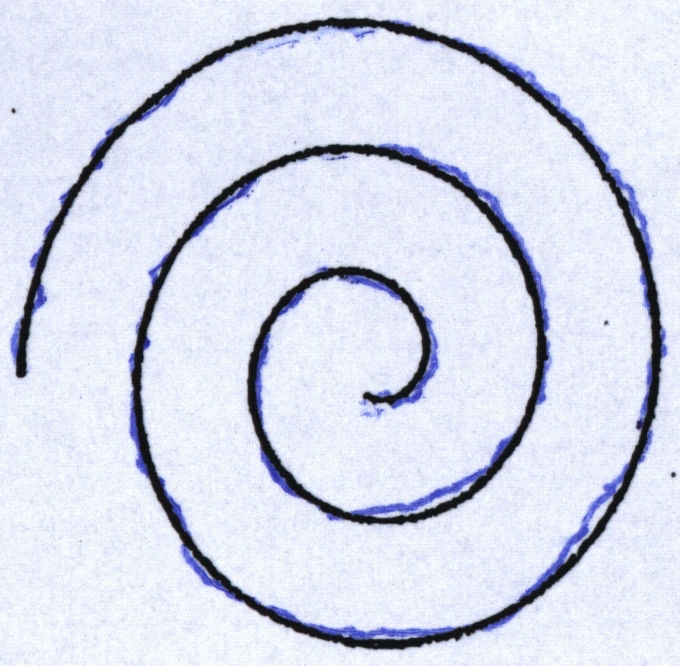

In [4]:
path = '../data/raw/NewHandPD/PatientSpiral'
name = 'sp1-P1.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.optimizers import SGD
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
batch_size = 7
learning_rate = 0.0001
momentum = 0.7
l2_reg = 0.0005
epochs = 30
image_size = (224, 224)
seed = 1

# No Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    "../data/raw/NewHandPD/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    seed=seed
)

val_generator = train_datagen.flow_from_directory(
    "../data/raw/NewHandPD/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    seed=seed
)

Found 238 images belonging to 2 classes.


Found 26 images belonging to 2 classes.


In [8]:
def make_model(learning_rate, momentum, l2_reg):
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    outputs = keras.layers.Dense(2, activation="softmax", kernel_regularizer=l2(l2_reg))(x)
    
    model = keras.Model(inputs, outputs)
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"]
    )
    
    return model

In [9]:
# model = make_model(learning_rate, momentum, l2_reg)
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=epochs,
# )

# val_generator.reset()
# predictions = model.predict(val_generator)
# predicted_labels = (predictions[:, 1] >= 0.5).astype(int) 

# true_labels = val_generator.classes

# accuracy = np.mean(predicted_labels == true_labels)
# print(f"Thresholded Validation Accuracy: {accuracy:.4f}")

In [10]:
from sklearn.model_selection import KFold
import os

In [11]:
data_dir = "../data/raw/NewHandPD/"
healthy_dir = os.path.join(data_dir, "HealthySpiral")
patient_dir = os.path.join(data_dir, "PatientSpiral")

healthy_images = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir)]
patient_images = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir)]

images = healthy_images + patient_images
labels = [0] * len(healthy_images) + [1] * len(patient_images)  

images = np.array(images)
labels = np.array(labels)

In [12]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_no = 1
# results = []

In [13]:
def predict_with_threshold(model, generator, threshold=0.5):
    predictions = model.predict(generator)
    predicted_labels = np.argmax(predictions, axis=1)  
    return predicted_labels

In [14]:
# for train_index, val_index in kf.split(images):
#     print(f"Training on fold {fold_no}...")

#     X_train, X_val = images[train_index], images[val_index]
#     y_train, y_val = labels[train_index], labels[val_index]

#     train_datagen = ImageDataGenerator(
#         preprocessing_function=preprocess_input,
#         brightness_range=[0.8, 1.2], 
#     )

#     val_datagen = ImageDataGenerator(
#         preprocessing_function=preprocess_input,
#     )

#     train_generator = train_datagen.flow_from_dataframe(
#         pd.DataFrame({"filename": X_train, "class": y_train}),
#         x_col="filename",
#         y_col="class",
#         target_size=image_size,
#         class_mode="raw", 
#         batch_size=batch_size,
#         shuffle=True,
#         seed=seed,
#     )

#     val_generator = val_datagen.flow_from_dataframe(
#         pd.DataFrame({"filename": X_val, "class": y_val}),
#         x_col="filename",
#         y_col="class",
#         target_size=image_size,
#         class_mode="raw",
#         batch_size=batch_size,
#         shuffle=False,
#         seed=seed,
#     )

#     model = make_model(learning_rate, momentum, l2_reg)

#     history = model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=epochs,
#     )

#     val_predictions = predict_with_threshold(model, val_generator, threshold=0.5)
#     val_accuracy = np.mean(val_predictions == y_val)  
#     results.append(val_accuracy)
#     print(f"Fold {fold_no} - Val Accuracy: {val_accuracy:.4f}")
#     fold_no += 1

# print("Cross-validation results:", results)
# print("Mean accuracy:", np.mean(results))
# print("Standard deviation:", np.std(results))

# With Augmentation

In [15]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,
    brightness_range=[0.8, 1.2],
)

train_generator = train_datagen.flow_from_directory(
    "../data/raw/NewHandPD/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    seed=seed,
)

val_generator = train_datagen.flow_from_directory(
    "../data/raw/NewHandPD/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    seed=seed,
)

Found 238 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [16]:
# for train_index, val_index in kf.split(images):
#     print(f"Training on fold {fold_no}...")

#     X_train, X_val = images[train_index], images[val_index]
#     y_train, y_val = labels[train_index], labels[val_index]

#     train_datagen = ImageDataGenerator(
#         preprocessing_function=preprocess_input,
#         brightness_range=[0.8, 1.2], 
#     )

#     val_datagen = ImageDataGenerator(
#         preprocessing_function=preprocess_input,
#     )

#     train_generator = train_datagen.flow_from_dataframe(
#         pd.DataFrame({"filename": X_train, "class": y_train}),
#         x_col="filename",
#         y_col="class",
#         target_size=image_size,
#         class_mode="raw", 
#         batch_size=batch_size,
#         shuffle=True,
#         seed=seed,
#     )

#     val_generator = val_datagen.flow_from_dataframe(
#         pd.DataFrame({"filename": X_val, "class": y_val}),
#         x_col="filename",
#         y_col="class",
#         target_size=image_size,
#         class_mode="raw",
#         batch_size=batch_size,
#         shuffle=False,
#         seed=seed,
#     )

#     model = make_model(learning_rate, momentum, l2_reg)

#     history = model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=epochs,
#     )

#     val_predictions = predict_with_threshold(model, val_generator, threshold=0.5)
#     val_accuracy = np.mean(val_predictions == y_val)  
#     results.append(val_accuracy)
#     print(f"Fold {fold_no} - Val Accuracy: {val_accuracy:.4f}")
#     fold_no += 1

# print("Cross-validation results:", results)
# print("Mean accuracy:", np.mean(results))
# print("Standard deviation:", np.std(results))

In [17]:
from keras.callbacks import ModelCheckpoint

In [18]:

checkpoint_dir = "../models"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5"),
    monitor="val_accuracy",

    save_best_only=True,
    mode="max"
)

full_train_generator = train_datagen.flow_from_directory(
    "../data/raw/NewHandPD/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    seed=seed,
    shuffle=True
)

model = make_model(learning_rate, momentum, l2_reg)

history = model.fit(
    full_train_generator,
    epochs=epochs,
    validation_data=val_generator, 
    callbacks=[checkpoint_callback]
)

print("Checkpointing complete.")


Found 264 images belonging to 2 classes.


2024-10-31 06:21:21.955182: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 06:21:21.956339: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.6515

/home/andakara/anaconda3/envs/.parked-ml-dev-venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 14s 281ms/step - loss: 0.6701 - accuracy: 0.6515 - val_loss: 0.5365 - val_accuracy: 0.7692
Epoch 2/30
38/38 [==============================] - 9s 224ms/step - loss: 0.5254 - accuracy: 0.7500 - val_loss: 0.4802 - val_accuracy: 0.7692
Epoch 3/30
38/38 [==============================] - 8s 199ms/step - loss: 0.4865 - accuracy: 0.7538 - val_loss: 0.4449 - val_accuracy: 0.7692
Epoch 4/30
38/38 [==============================] - 10s 255ms/step - loss: 0.4430 - accuracy: 0.7689 - val_loss: 0.4567 - val_accuracy: 0.8077
Epoch 5/30
38/38 [==============================] - 7s 192ms/step - loss: 0.4408 - accuracy: 0.7917 - val_loss: 0.4180 - val_accuracy: 0.7692
Epoch 6/30
38/38 [==============================] - 8s 200ms/step - loss: 0.4297 - accuracy: 0.7879 - val_loss: 0.4644 - val_accuracy: 0.8077
Epoch 7/30
38/38 [==============================] - 8s 204ms/step - loss: 0.4008 - accuracy: 0.7879 - val_loss: 0.3537 - val_accuracy: 0.8846
Epoch 8/30
38/3

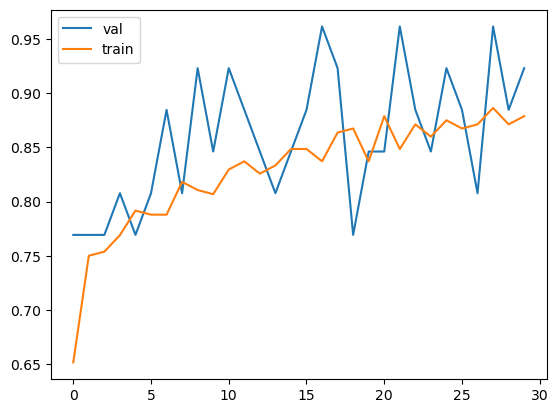

In [19]:
plt.plot(history.history['val_accuracy'], label='val')
plt.plot(history.history['accuracy'], label='train')
plt.legend()

# Testing final model

In [30]:
model = keras.models.load_model('../models/model_epoch_17_val_acc_0.9615.h5')

In [37]:
path = './sp1-P1.jpg'

In [38]:
img = load_img(path, target_size=(224, 224))

In [39]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 224, 224, 3)

In [40]:
X = preprocess_input(X)

In [41]:
pred = model.predict(X)

1/1 [==============================] - 1s 811ms/step


In [42]:
pred

array([[0.06517317, 0.93482685]], dtype=float32)

: 

# Finding best threshold for final prediction

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [28]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = np.array(img)
    x = preprocess_input(np.expand_dims(x, axis=0))
    return x

1/1 [==============================] - 0s 70ms/step


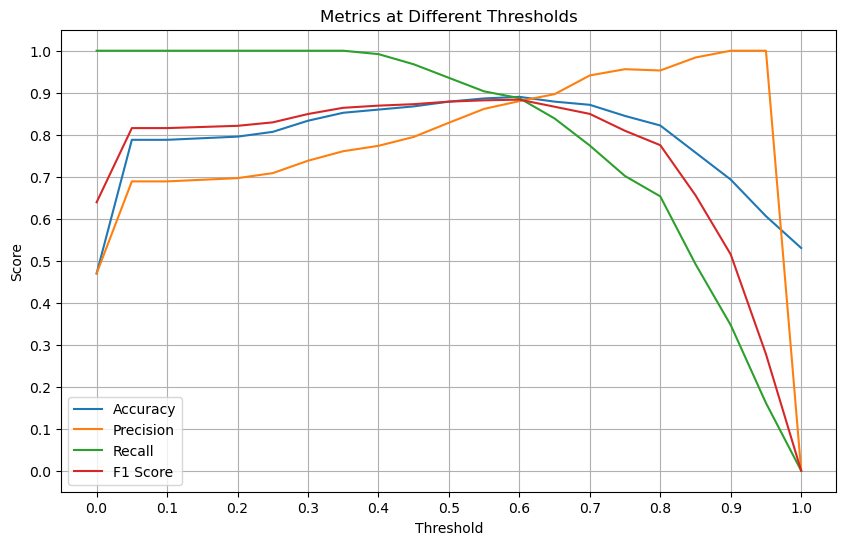

In [29]:
y_true = np.array(labels)
y_pred_probs = []

for img_path in images:
    x = preprocess_image(img_path)
    pred = model.predict(x)
    y_pred_probs.append(pred[0][1])

thresholds = np.arange(0, 1.05, 0.05)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred = [1 if prob >= threshold else 0 for prob in y_pred_probs]
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_true, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, zero_division=0))


plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label="Accuracy")
plt.plot(thresholds, precision_scores, label="Precision")
plt.plot(thresholds, recall_scores, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Metrics at Different Thresholds")
plt.legend()
plt.grid()
plt.show()